## Workflow to analyze DeepLabCut data

### Imports

In [1]:
# Import Session and Experiment class with helper functions
%load_ext autoreload
%autoreload 2 

# Import Session and Experiment class with helper functions
from trialexp.process.data_import import *

        if you want to export datasets to perform Maching Learning tasks.
        To solve, type pip install sktime in your environment


### Variables
- A tasks definition file (.csv) contains all the information to perform the extractions of behaviorally relevant information from **PyControl** files, for each **task** file. It includes what are the **triggers** of different trial types, what **events** to extract (with time data), and what are events or printed lines that could be relevant to determine the **conditions** (e.g: free reward, optogenetic stimulation type, etc.)

In [3]:
import pandas as pd

trial_window = [-2000, 6000] # in ms

# time limit around trigger to perform an event
# determine successful trials
timelim = [0, 4000] # in ms

# Digital channel nb of the pyphotometry device
# on which rsync signal is sent (from pycontrol device)
rsync_chan = 2

basefolder, _ = os.path.split(os.getcwd())

# These must be absolute path
tasksfile = os.path.join(basefolder,'params/tasks_params.csv')
photometry_dir = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\test_folder\photometry'
video_dir = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\videos'

# To analyze a new task you need to append task characteristics
# like task filename, triggers, events and opto_categories print events
tasks = pd.read_csv(tasksfile, usecols = [1,2,3,4], index_col = False)
tasks

,task,triggers,events,conditions
0,lick_go_nogo,go; nogo,bar; bar_off; spout,free_reward
1,lick_go_nogo_unconditionned,go; nogo,bar; bar_off; spout,free_reward
2,lick_go_nogo_unconditionned_opto,go; nogo,bar; bar_off; spout,free_reward
3,reaching_go_nogo,CS_Go; CS_NoGo,bar; bar_off; spout,error bar_off; reward bar_off; error free; rew...
4,reaching_go_nogo_jc,CS_plus; CS_minus,bar; bar_off; spout,error bar_off; reward bar_off; error free; rew...
5,reaching_go_nogo_opto_continuous,CS_Go; CS_NoGo,bar; bar_off; spout,s_nogo_sham; s_nogo_cs_onset; s_go_sham; s_go_...
6,reaching_go_nogo_opto_sinusoid,CS_Go; CS_NoGo,bar; bar_off; spout,s_nogo_sham; s_nogo_cs_onset_2; s_nogo_cs_onse...
7,reaching_go_nogo_opto_sinusoid_spout,CS_Go; CS_NoGo,bar; bar_off; spout,s_nogo_sham; s_nogo_cs_onset_2; s_nogo_cs_onse...
8,reaching_go_nogo_reversal,CS_Go; CS_NoGo,bar; bar_off; spout,error bar_off; reward bar_off; error free; rew...
9,reaching_go_nogo_reversal_incentive,CS_Go; CS_NoGo,bar; bar_off; spout,error bar_off; reward bar_off; error free; rew...


### Create an experiment object

This will include all the pycontrol files present in the folder_path directory (do not include subdirectories)

In [4]:
# Folder of a full experimental batch, all animals included
# pycontrol_files_path = r'T:\Data\head-fixed\test_folder\pycontrol'
# or 
pycontrol_files_path = os.path.join(basefolder,'sample_data/pycontrol')
# Load all raw text sessions in the indicated folder or a sessions.pkl file
# if already existing in folder_path
exp_cohort = Experiment(pycontrol_files_path)

# Only use if the Experiment cohort as been processed by trials before
exp_cohort.by_trial = True

Saved sessions loaded from: sessions.pkl


### Perform extraction of behavioural information by trial

In [ ]:
# Process the whole experimental folder by trials
exp_cohort.process_exp_by_trial(trial_window, timelim, tasksfile)

# Save the file as sessions.pkl in folder_path
exp_cohort.save()

### Match with photometry, videos, and DeepLabCut files

In [ ]:
# Find if there is a matching photometry file and if it can be used:
# rsync synchronization pulses matching between behaviour and photometry
exp_cohort.match_to_photometry_files(photometry_dir, rsync_chan, verbose=False)

# Find matching videos
exp_cohort.match_sessions_to_files(video_dir, ext='mp4')

# FInd matching DeepLabCut outputs files
exp_cohort.match_sessions_to_files(video_dir, ext='h5', verbose=True)

exp_cohort.save()


### Define conditions and groups for extraction

In [5]:
# Defime each trial type as a dictionary of conditions to be met
# Defime each trial type as a dictionary of conditions to be met
conditions_dict1 = {'trigger': 'CS_Go', 'valid': True, 'success': True, 'error bar_off': False, 'reward free': False, 'button_press': False}
conditions_dict2 = {'trigger': 'CS_Go', 'valid': True, 'success': False, 'error bar_off': False, 'reward free': False, 'button_press': False}
conditions_dict3 = {'trigger': 'CS_NoGo', 'valid': True, 'success': True, 'button_press': False}
conditions_dict4 = {'trigger': 'CS_NoGo', 'valid': True, 'success': False, 'button_press': False}
# Aggregate all condition dictionaries in a list
condition_list = [conditions_dict1, conditions_dict2, conditions_dict3, conditions_dict4]
# Aliases for conditions
cond_aliases = ['Go hit', 'Go miss', 'NoGo hit', 'NoGo miss']
# Groups as a list of lists
# groups = [[280, 281, 282, 289],[295, 282, 284, 285, 292, 297]]
groups = None

# Window to exctract (in ms)
trial_window = [-2000, 6000]





Another example, for Go-NoGo optogenetic protocol

In [117]:
conditions_dict0 = {'trigger': 'CS_Go', 'valid': True, 's_go_sham': True}
conditions_dict1 = {'trigger': 'CS_Go', 'valid': True, 's_go_cs_onset': True}
conditions_dict2 = {'trigger': 'CS_Go', 'valid': True, 's_go_bar_off': True}
conditions_dict3 = {'trigger': 'CS_Go', 'valid': True, 's_go_spout': True}
conditions_dict4 = {'trigger': 'CS_Go', 'valid': True, 's_go_error_sham': True}
conditions_dict5 = {'trigger': 'CS_Go', 'valid': True, 's_go_error_bar_off': True}
conditions_dict6 = {'trigger': 'CS_NoGo', 'valid': True, 's_nogo_sham': True}
conditions_dict7 = {'trigger': 'CS_NoGo', 'valid': True, 's_nogo_cs_onset': True}

# Aggregate all condition dictionaries in a list
condition_list = [conditions_dict0, conditions_dict1, conditions_dict2, conditions_dict3, \
    conditions_dict4, conditions_dict5, conditions_dict6, conditions_dict7]
# Aliases for conditions
cond_aliases = ['Go sham', 'Go onset', 'Go bar release', \
    'Go spout', 'Go error sham', 'Go error bar_off', 'NoGo sham', 'NoGo onset']
# Groups as a list of lists
groups = [[280, 282, 283, 294, 295, 299, 300, 301, 302, 303, 304, 305],\
    [284, 285, 296, 297, 306, 307],[289,290,291,292,293]]

# right_handed = [281]
# groups = [[280, 282, 299, 300, 301],\
#     [284, 285, 296, 297, 306, 307]]
# Window to exctract (in ms)
trial_window = [-2000, 6000]

Example in progress for Cued-Uncued

In [ ]:
# List of uncued conditions as listed on the tasks .csv file for task reaching_go_spout_cued_uncued:
# free_reward_timer; reward spout cued; reward bar cued; reward bar_off; reward spout uncued; reward bar uncued; reward free; reward free_uncued

# Many combinations possible
conditions_dict0 = {'trigger': 'cued', 'valid': True, 'reward spout cued': True, 'free_reward_timer': False, 'success': True}
conditions_dict1 = {'trigger': 'cued', 'valid': True, 'reward bar cued': True, 'free_reward_timer': False, 'success': True}
conditions_dict2 = {'trigger': 'cued', 'valid': True, 'success': False}
conditions_dict3 = {'trigger': 'uncued', 'valid': True, 'success': False}
conditions_dict4 = {'trigger': 'uncued', 'valid': True, 'reward spout uncued': True, 'free_reward_timer': False, 'success': True}
conditions_dict5 = {'trigger': 'uncued', 'valid': True, 'reward bar cued': True, 'free_reward_timer': False, 'success': True}

# Aggregate all condition dictionaries in a list
condition_list = [conditions_dict0, conditions_dict1, conditions_dict2, conditions_dict3, \
    conditions_dict4, conditions_dict5]
# Aliases for conditions
cond_aliases = ['Cued spout hit', 'Cued bar hit', 'Cued miss', \
    'Uncued miss', 'Uncued spout hit', 'Uncued bar hit']
# Groups as a list of lists
groups = None

# right_handed = [281]
# groups = [[280, 282, 299, 300, 301],\
#     [284, 285, 296, 297, 306, 307]]
# Window to exctract (in ms)
trial_window = [-2000, 6000]

Behaviour: Create a dataset

In [7]:
ev_dataset = exp_cohort.behav_events_to_dataset(
        groups = groups,
        conditions_list = condition_list, 
        cond_aliases = cond_aliases, 
        when = 'all', 
        task_names = 'reaching_go_nogo',
        trig_on_ev = None)

ev_dataset.set_trial_window(trial_window=trial_window, unit='milliseconds')
ev_dataset.set_conditions(conditions=condition_list, aliases=cond_aliases)

Behaviour: Compute distribution

In [28]:
trial_window[0], trial_window[1]

IndexError: tuple index out of range

In [31]:
bin_size = 100
trial_window = [-2000, 30000]
bins = range(trial_window[0], trial_window[1]+1, bin_size)
[bin for bin in bins]

[-2000,
 -1900,
 -1800,
 -1700,
 -1600,
 -1500,
 -1400,
 -1300,
 -1200,
 -1100,
 -1000,
 -900,
 -800,
 -700,
 -600,
 -500,
 -400,
 -300,
 -200,
 -100,
 0,
 100,
 200,
 300,
 400,
 500,
 600,
 700,
 800,
 900,
 1000,
 1100,
 1200,
 1300,
 1400,
 1500,
 1600,
 1700,
 1800,
 1900,
 2000,
 2100,
 2200,
 2300,
 2400,
 2500,
 2600,
 2700,
 2800,
 2900,
 3000,
 3100,
 3200,
 3300,
 3400,
 3500,
 3600,
 3700,
 3800,
 3900,
 4000,
 4100,
 4200,
 4300,
 4400,
 4500,
 4600,
 4700,
 4800,
 4900,
 5000,
 5100,
 5200,
 5300,
 5400,
 5500,
 5600,
 5700,
 5800,
 5900,
 6000,
 6100,
 6200,
 6300,
 6400,
 6500,
 6600,
 6700,
 6800,
 6900,
 7000,
 7100,
 7200,
 7300,
 7400,
 7500,
 7600,
 7700,
 7800,
 7900,
 8000,
 8100,
 8200,
 8300,
 8400,
 8500,
 8600,
 8700,
 8800,
 8900,
 9000,
 9100,
 9200,
 9300,
 9400,
 9500,
 9600,
 9700,
 9800,
 9900,
 10000,
 10100,
 10200,
 10300,
 10400,
 10500,
 10600,
 10700,
 10800,
 10900,
 11000,
 11100,
 11200,
 11300,
 11400,
 11500,
 11600,
 11700,
 11800,
 11900,
 

In [8]:
dist_as_continuous = ev_dataset.compute_distribution(
        trial_window = [-2000, 30000],
        bin_size = 1000, # do not work as expected with cued-uncued
        normalize = True,
        per_session = False,
        out_as_continuous = True)
dist_as_continuous.set_conditions(conditions=condition_list, aliases=cond_aliases)
# Remove test files
dist_as_continuous.filter_subjects([0,1])

Beheviour: optional methods

In [9]:
# Get a list of the groups
dist_as_continuous.get_groups()
# Get a list of the variables
dist_as_continuous.get_col_names()

# reset previous filtering of the dataset
dist_as_continuous.filter_reset()

# exclude some conditions by IDs
dist_as_continuous.filter_conditions([])

# exclude some groups by IDs
dist_as_continuous.filter_groups([])

# exclude some subjects
dist_as_continuous.filter_subjects([0, 1])
#     subjects_IDs_to_exclude = [289, 290, 293, 294, 295, 299, 301, 303, 304, 305, 306])

# filter subjects/sessions with less than x trials (by condition)
# dist_as_continuous.filter_min(min_trials = 1)

# To remove subjects who do not have
# trials in all the conditions
# dist_as_continuous.filter_if_not_in_all_cond()


Behaviour: Plot distribution

        if you want to export datasets to perform Maching Learning tasks.
        To solve, type pip install sktime in your environment
 conditions Int64Index([0, 1, 2, 3], dtype='int64', name='condition_ID') groups Int64Index([0], dtype='int64', name='group_ID')


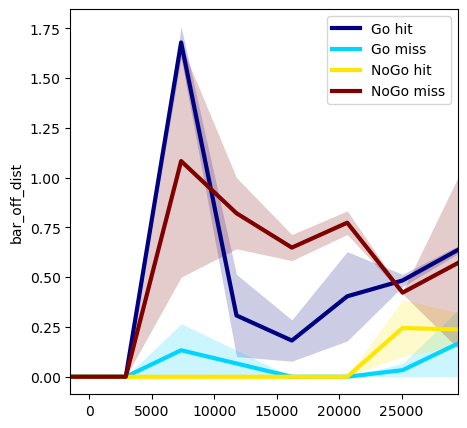

True    8
Name: keep, dtype: int64

In [21]:
dist_as_continuous.lineplot(
    vars = [ 'bar_off_dist'],
    time_lim = None,
    error = True,
    ylim = None,#[[-0.1,1.6]], #[[-0.1, 0.7]], #[[-0.1, 1]],#,[-0.005, 0.007]],#[[-0.001, 0.0011],[-0.001, 0.0011]],
    colormap = 'jet',
    legend = True,
    plot_subjects = False,
    plot_groups = True,
    figsize = (5,5),
    dpi = 100,
    verbose = False)
# Return a count of overall number of trials
dist_as_continuous.metadata_df['keep'].value_counts()

### Set DeepLabCut bodyparts to compute paws centroids

In [158]:
# Name of the labelled body parts from both upper limbs
# The bodyparts from which we draw here are user-defined
# when creating a new DeepLabCut project (config.yaml)

L_paw_parts  = ['MCP II', 'MCP III', 'MCP IV', 'MCP V', 'IP II', 'IP III', \
    'IP IV', 'IP V', 'tip II', 'tip III', 'tip IV', 'tip V'] 

R_paw_parts = ['r MCP II', 'r MCP III', 'r MCP IV', 'r MCP V', 'r IP II', \
    'r IP III', 'r IP IV', 'r IP V', 'r tip II', 'r tip III', 'r tip IV', 'r tip V']

names_of_ave_regions = ['Left_paw','Right_paw']

### Extract DeepLabCut trials and create a Continuous_Dataset

In [ ]:
cont_dataset = exp_cohort.get_deeplabcut_groups(
        groups = None,
        conditions_list = condition_list,
        cond_aliases = cond_aliases,
        when='all', 
        task_names = ['reaching_go_nogo'],
        bodyparts_to_ave = [L_paw_parts, R_paw_parts],
        names_of_ave_regions = ['Left_paw','Right_paw'], 
        bodyparts_to_store = ['spout', 'jaw', 'ear', 'tongue', 'tip III',  'IP III', 'MCP III'],
        normalize_between = ['Left_paw', 'spout'],
        bins_nb = 100,
        three_dims = False, 
        p_thresh = 0.9,
        camera_fps = 100, # not yet functional
        camera_keyword = 'Side', 
        trig_on_ev = None, 
        verbose = True)


### Save DLC Dataset

In [338]:
folder_path = r'C:\Users\phar0732\Documents\GitHub\pycontrol_share\outputs'

cont_dataset.save(folder_path, 'DLC_dataset_gonogo')

PicklingError: Can't pickle <class 'trial_dataset_classes.Continuous_Dataset'>: it's not the same object as trial_dataset_classes.Continuous_Dataset

### Reload a pre-existing dataset

In [110]:
dataset_full_path = r'C:\Users\phar0732\Documents\GitHub\pycontrol_share\outputs\DLC_dataset_opto_continuous_full.pkl'
cont_dataset = load_dataset(dataset_full_path)

In [111]:
cont_dataset.metadata_df

,subject_ID,datetime,task_name,condition_ID,trial_nb,session_nb,group_ID,keep,trial_ID
0,280,2021-11-18 15:11:25,reaching_go_nogo_opto_continuous,0,8,34,0,False,0
1,280,2021-11-18 15:11:25,reaching_go_nogo_opto_continuous,0,11,34,0,False,1
2,280,2021-11-18 15:11:25,reaching_go_nogo_opto_continuous,0,12,34,0,False,2
3,280,2021-11-18 15:11:25,reaching_go_nogo_opto_continuous,0,19,34,0,False,3
4,280,2021-11-18 15:11:25,reaching_go_nogo_opto_continuous,0,22,34,0,False,4
...,...,...,...,...,...,...,...,...,...
9114,293,2022-01-21 15:31:54,reaching_go_nogo_opto_continuous,7,60,37,2,False,9114
9115,293,2022-01-21 15:31:54,reaching_go_nogo_opto_continuous,7,64,37,2,False,9115
9116,293,2022-01-21 15:31:54,reaching_go_nogo_opto_continuous,7,142,37,2,False,9116
9117,293,2022-01-21 15:31:54,reaching_go_nogo_opto_continuous,7,144,37,2,False,9117


### Optional methods

In [374]:
# Get a list of the groups
cont_dataset.get_groups()
# Get a list of the variables
cont_dataset.get_col_names()

# reset previous filtering of the dataset
cont_dataset.filter_reset()

# exclude some conditions by IDs
cont_dataset.filter_conditions([])

# exclude some groups by IDs
cont_dataset.filter_groups([])

# exclude some subjects
cont_dataset.filter_subjects([0, 1,289,299,305,306])
#     subjects_IDs_to_exclude = [289, 290, 293, 294, 295, 299, 301, 303, 304, 305, 306])

# filter subjects/sessions with less than x trials (by condition)
cont_dataset.filter_min(min_trials = 10)

# To remove subjects who do not have
# trials in all the conditions
# cont_dataset.filter_if_not_in_all_cond()

# method to build (not finished)
# cont_dataset.set_groups()


In [375]:
%load_ext autoreload
%autoreload 2

from trial_dataset_classes import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


 conditions Int64Index([0, 1, 2, 3], dtype='int64', name='condition_ID') groups Int64Index([0], dtype='int64', name='group_ID')


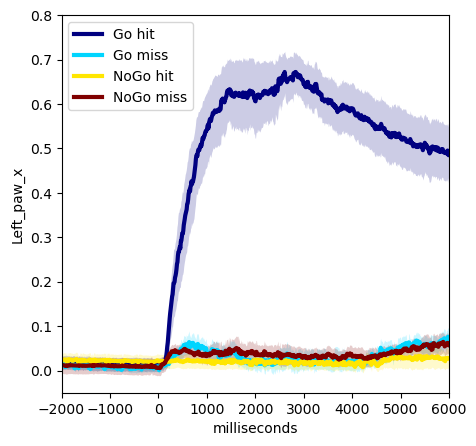

True     2800
False     628
Name: keep, dtype: int64

In [378]:
### Plot the photometry by condition
cont_dataset.set_trial_window([-2, 6], 's')
cont_dataset.set_conditions(condition_list, cond_aliases)
cont_dataset.lineplot(
    vars = ['Left_paw_x'],
    time_lim = [-2000, 6000],
    time_unit = 'milliseconds',
    error = True,
    ylim = [[-0.05, 0.8]], #[[-0.1, 1]],#,[-0.005, 0.007]],#[[-0.001, 0.0011],[-0.001, 0.0011]],
    colormap = 'jet',
    legend = True,
    plot_subjects = False,
    plot_groups = True,
    figsize = (5,5),
    dpi = 100,
    verbose = False)

# Return a count of overall number of trials
cont_dataset.metadata_df['keep'].value_counts()


In [ ]:
%load_ext autoreload
%autoreload 2
cont_dataset.set_groups(groups)

In [276]:
cont_dataset.metadata_df.keep[cont_dataset.metadata_df.subject_ID == 307].value_counts()

True     308
False    233
Name: keep, dtype: int64

In [177]:
for row in cont_dataset.metadata_df.itertuples():
    print(row.group_ID)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [171]:
row

Pandas(Index=0, subject_ID=0, datetime=Timestamp('2021-11-18 14:37:48'), task_name='reaching_go_nogo_opto_continuous', condition_ID=0, trial_nb=4, session_nb=160, group_ID=0, keep=False, trial_ID=0)

In [172]:
row.subject_ID

0